In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
train_dataset = torchvision.datasets.FashionMNIST(
    root='.',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [ ]:
train_dataset.data.max()

tensor(255, dtype=torch.uint8)

In [ ]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [ ]:
train_dataset.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [ ]:
test_dataset = torchvision.datasets.FashionMNIST(
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

In [ ]:
test_dataset.data.shape

torch.Size([10000, 28, 28])

In [ ]:
# number of classes
K = len(set(train_dataset.targets.numpy()))
print(f'number of classes: {K}')

number of classes: 10


In [ ]:
# Define the model\
class CNN(nn.Module):
  def __init__(self, K):
    super(CNN, self).__init__()
    self.conv_layers = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
        nn.ReLU()
    )
    self.dense_layers = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(128 * 2 * 2, 512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, K)
    )

  def forward(self,X):
    out = self.conv_layers(X)
    out = out.view(out.size(0), -1)
    out = self.dense_layers(out)
    return out

In [ ]:
# Instantiate the model
model = CNN(K)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
# Data loader
# Usefull because it automatically generates batches in the training loop
# and takes care of shuffling
batch_size = 128
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs=1000):
  # Stuff to store
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)
  for it in range(epochs):
    model.train()
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
      # move data to GPU
      inputs, targets = inputs.to(device), targets.to(device)

      # zer0 the parameter gradients
      optimizer.zero_grad()

      # forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading

    model.eval()

    test_loss = []
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - t0
    print(f"Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}")


  return train_losses, test_losses

In [ ]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader,
                                     epochs=15)

Epoch 1/15, Train Loss: 0.6519, Test Loss: 0.4723, Duration: 0:00:15.267754
Epoch 2/15, Train Loss: 0.4338, Test Loss: 0.4018, Duration: 0:00:07.619394
Epoch 3/15, Train Loss: 0.3783, Test Loss: 0.3642, Duration: 0:00:07.703652
Epoch 4/15, Train Loss: 0.3390, Test Loss: 0.3509, Duration: 0:00:07.606919
Epoch 5/15, Train Loss: 0.3112, Test Loss: 0.3397, Duration: 0:00:07.591174
Epoch 6/15, Train Loss: 0.2893, Test Loss: 0.3064, Duration: 0:00:09.838153
Epoch 7/15, Train Loss: 0.2731, Test Loss: 0.2965, Duration: 0:00:08.503090
Epoch 8/15, Train Loss: 0.2516, Test Loss: 0.2912, Duration: 0:00:07.684127
Epoch 9/15, Train Loss: 0.2402, Test Loss: 0.2840, Duration: 0:00:07.645607
Epoch 10/15, Train Loss: 0.2252, Test Loss: 0.2816, Duration: 0:00:07.605425
Epoch 11/15, Train Loss: 0.2113, Test Loss: 0.2818, Duration: 0:00:07.698640
Epoch 12/15, Train Loss: 0.2008, Test Loss: 0.2791, Duration: 0:00:08.127926
Epoch 13/15, Train Loss: 0.1870, Test Loss: 0.2813, Duration: 0:00:07.961162
Epoch 14

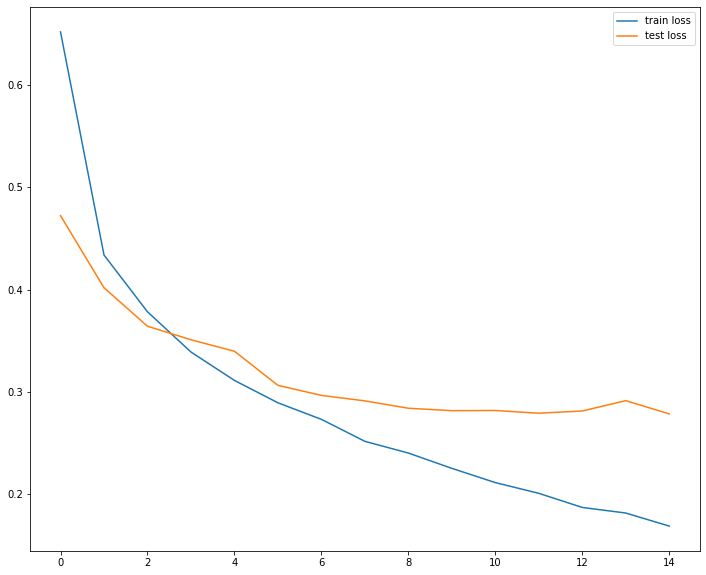

In [ ]:
# plot the train loss and test loss per iteration
plt.figure(figsize=(12,10))
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:
# Accuracy

model.eval()
n_correct = 0
n_total = 0
for inputs, targets in train_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)
  # forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct/n_total

n_correct = 0
n_total = 0
for inputs, targets in test_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)
  # forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct/n_total

print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9568, Test acc: 0.9038


In [ ]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting 'normalize=True'.
  """
  if normalize:
    cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix, without normalization")
  print(f"{cm}\n")
  plt.figure(figsize=(12,10))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max()/2
  for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i,format(cm[i,j],fmt),
             horizontalalignment='center',
             color='white' if cm[i,j] > thresh else 'black')
    
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization
[[842   1  22  32   3   1  94   0   5   0]
 [  3 976   0  15   1   0   4   0   1   0]
 [ 12   1 883  10  36   0  57   0   1   0]
 [  5   4  16 919  36   0  19   0   1   0]
 [  0   3  73  27 828   0  68   0   1   0]
 [  0   0   0   1   0 969   0  18   1  11]
 [ 95   0  72  26  69   1 726   0  11   0]
 [  0   0   0   0   0  15   0 954   0  31]
 [  1   2   9   1   5   1   2   3 975   1]
 [  0   0   0   0   0   4   1  29   0 966]]



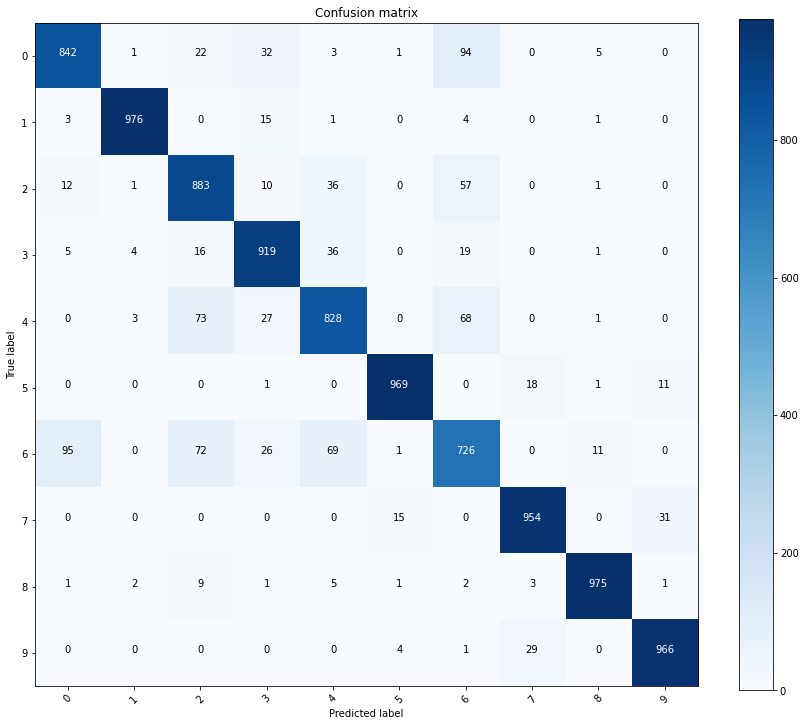

In [ ]:
# Get all predictions in an array and plot confusiuon matrix

x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])
for inputs, targets in test_loader:
  # move data to GPU
  inputs = inputs.to(device)
  # forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update p_test
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test,p_test)
plot_confusion_matrix(cm,list(range(10)))

In [ ]:
# Label mapping
labels = '''T-shirt/top
Trouser
Pullover
Dress
Coat
Sandal
Shirt
Sneaker
Bag
Ankle boot'''.split('\n')
labels

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Text(0.5, 1.0, 'True label: 6 Predicted 2')

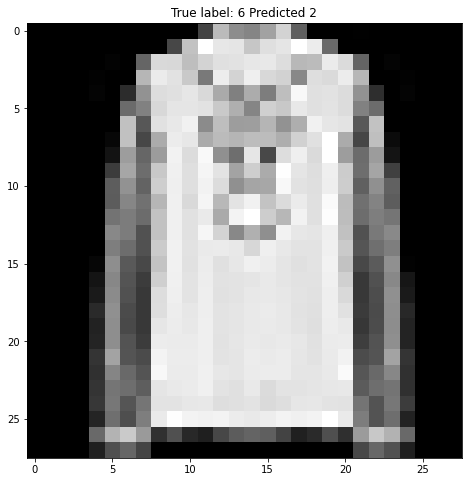

In [ ]:
# show some misclassified examples
p_test = p_test.astype(np.uint8)
misclassifed_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassifed_idx)
plt.figure(figsize=(8,8))
plt.imshow(x_test[i], cmap='gray')
plt.title("True label: %s Predicted %s" % (y_test[i], int(p_test[i])))